In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from DataParser import DataParser
from NaiveBayes import NaiveBayes

import numpy as np
import matplotlib.pyplot as plt

In [42]:
def visualize_data(predicted_labels, test_labels, allSNR=False, perSNR=False):
    if allSNR:
        ConfusionMatrixDisplay.from_predictions(test_labels.flatten(), predicted_labels.flatten(),)
        plt.title(f"Confusion matrix for all SNR values, accuracy: {np.mean(predicted_labels == test_labels)}")
        plt.show()
    if perSNR:
        accuracy = np.zeros(8)
        for i in range(8):
            accuracy[i] = np.mean(predicted_labels[i] == test_labels[i])
            ConfusionMatrixDisplay.from_predictions(test_labels[i].flatten(), predicted_labels[i].flatten(),)
            plt.title(f"Confusion matrix for SNR={dataSet.SNR[i]}, accuracy: {accuracy[i]}")
            plt.show()
        plt.plot(dataSet.SNR.values(), accuracy, marker="o")
        plt.title("Accuracy per SNR")
        plt.xlabel("SNR")
        plt.ylabel("Accuracy")


(8, 20000, 1)


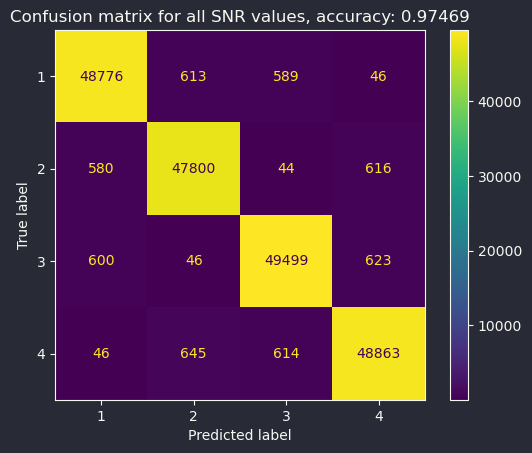

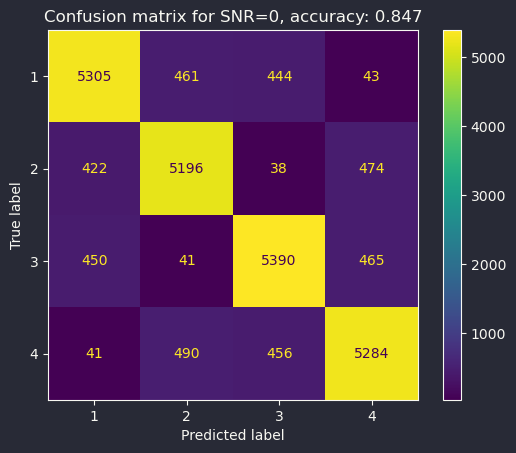

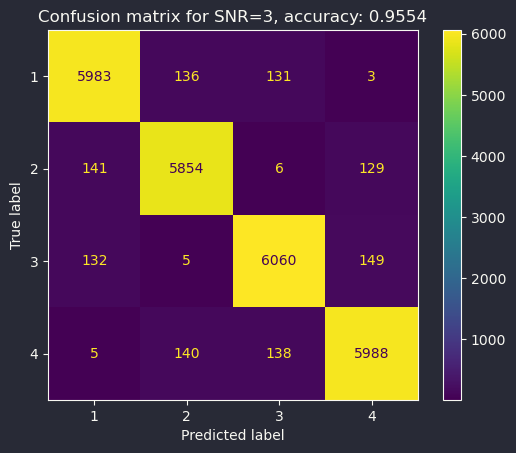

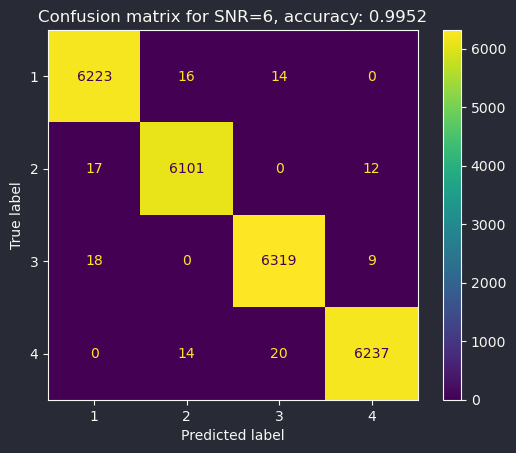

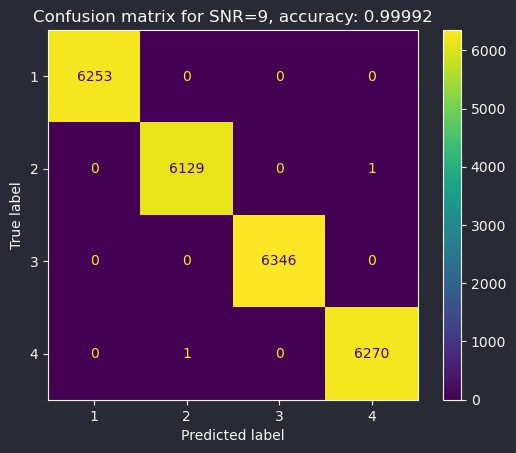

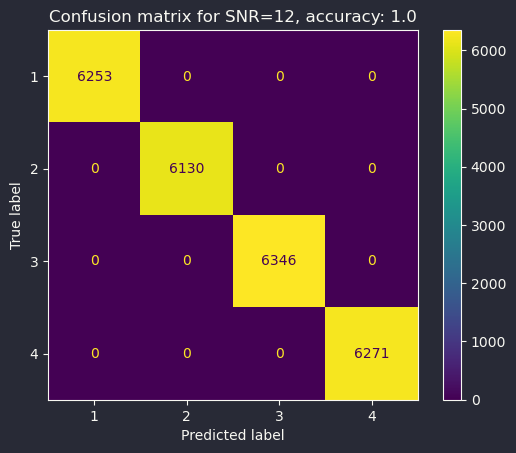

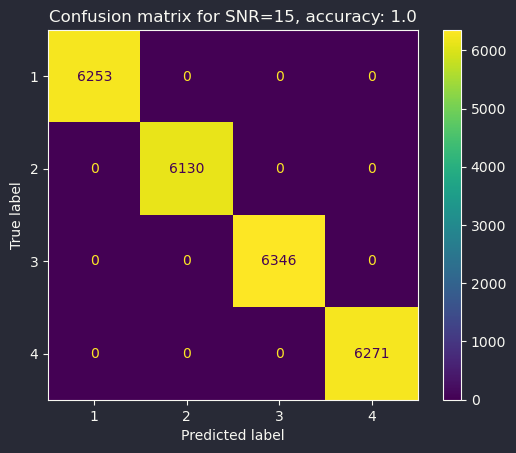

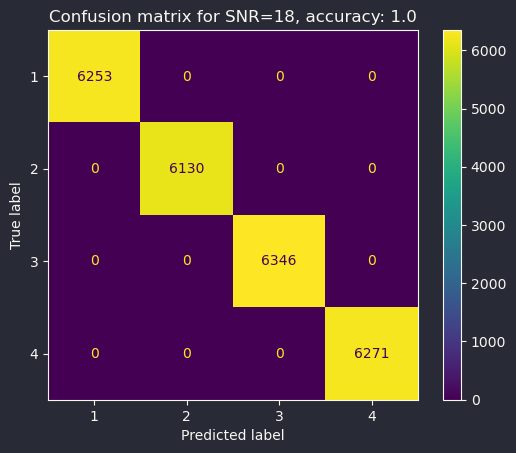

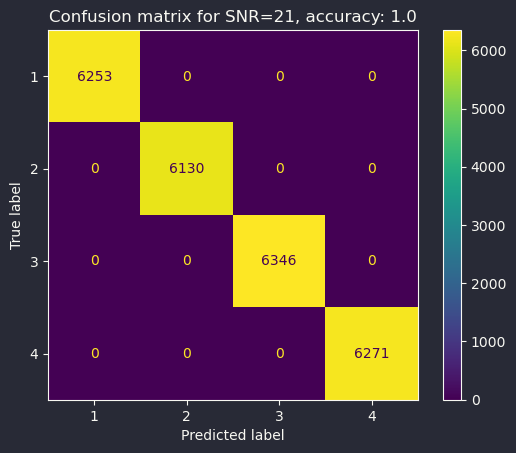

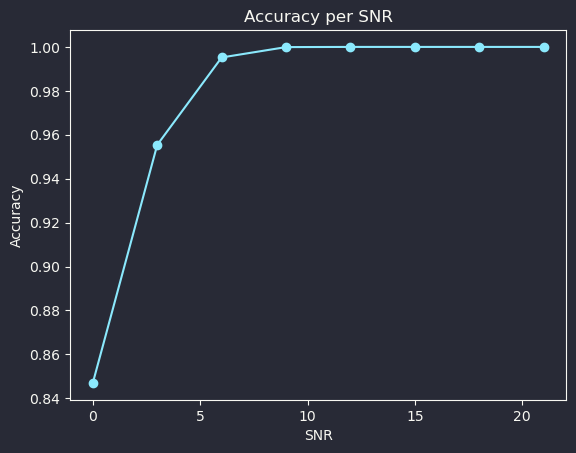

In [43]:
dataSet = DataParser("../data/DataForML.mat")
train_data, train_labels = dataSet.get_train_dataV1()
test_data, test_labels = dataSet.get_test_dataV1()

naiveBayesV1 = NaiveBayes()
naiveBayesV1.train(train_data, train_labels, np.unique(train_labels))

predicted_labels = naiveBayesV1.predict(test_data, np.unique(train_labels))

visualize_data(predicted_labels, test_labels, allSNR=True, perSNR=True)

(4, 20000, 1)


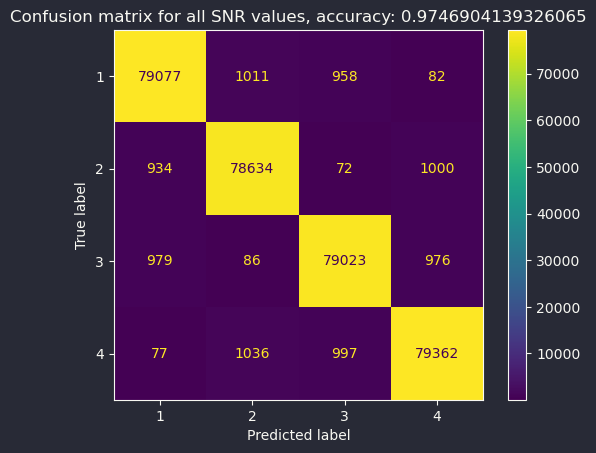

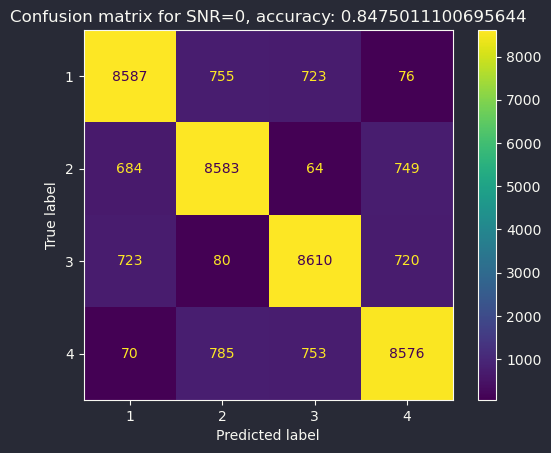

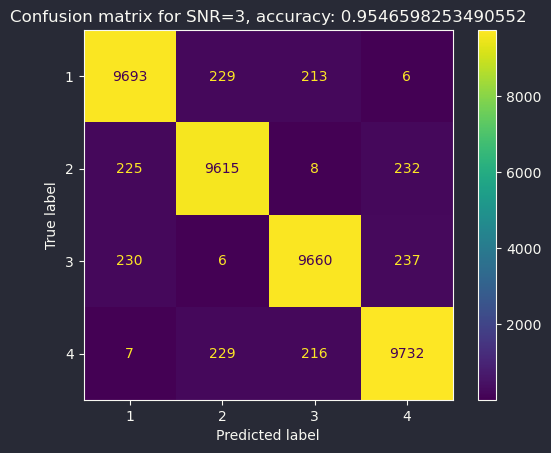

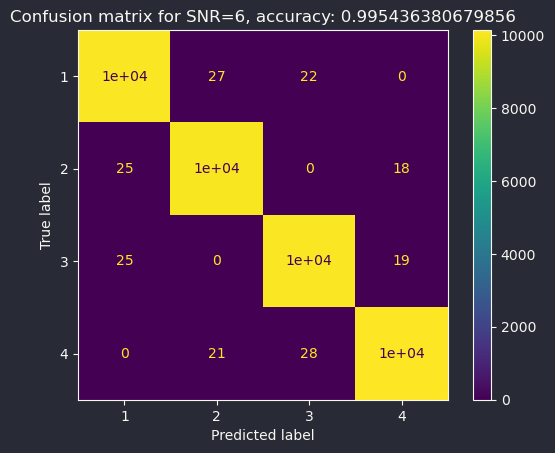

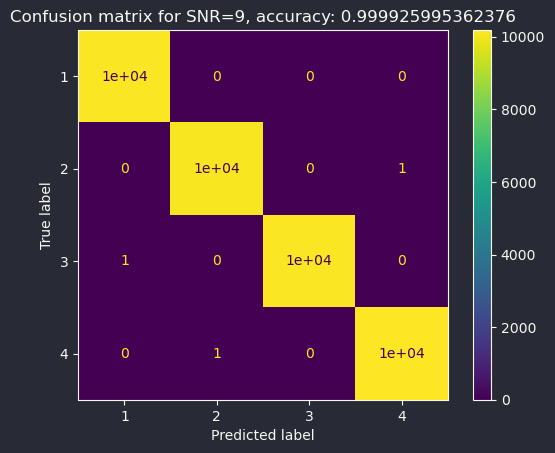

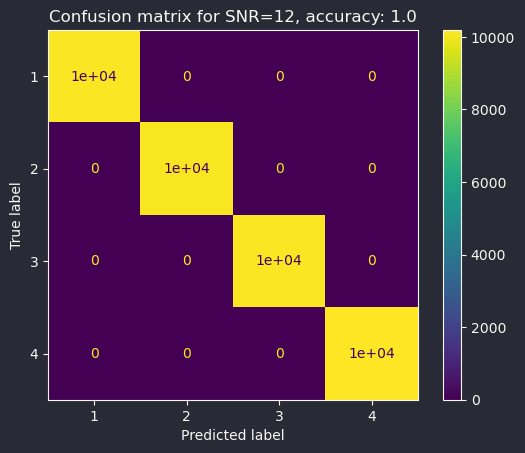

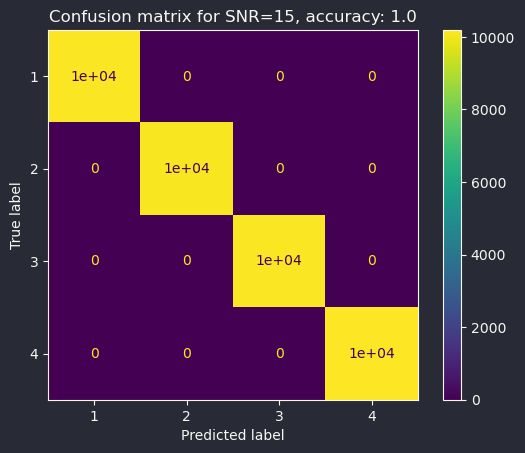

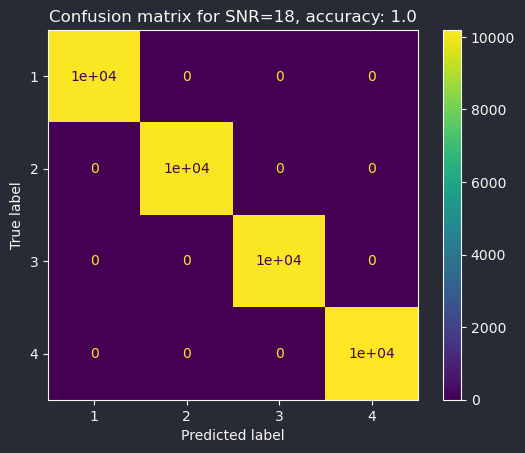

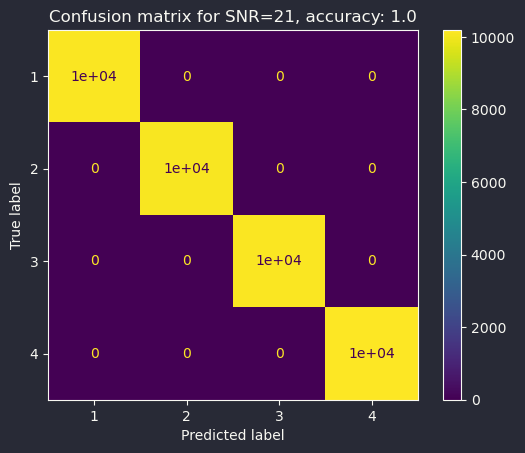

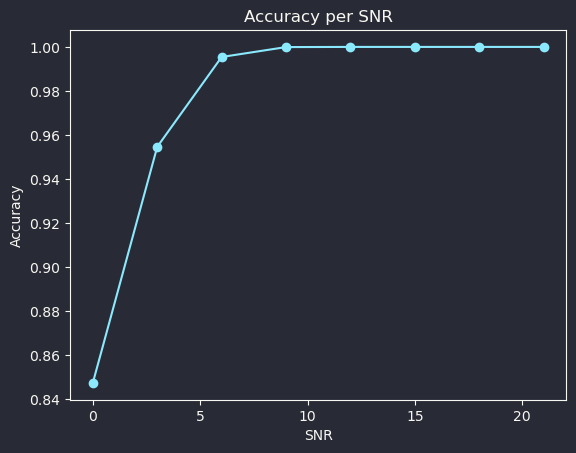

In [44]:
train_data, train_labels = dataSet.get_train_dataV2()
test_data, test_labels = dataSet.get_test_dataV2()

naiveBayesV2 = NaiveBayes()
naiveBayesV2.train(train_data, train_labels, np.unique(train_labels))

predicted_labels = naiveBayesV2.predict(test_data, np.unique(train_labels))
visualize_data(predicted_labels, test_labels, allSNR=True, perSNR=True)

(8, 20000, 3)


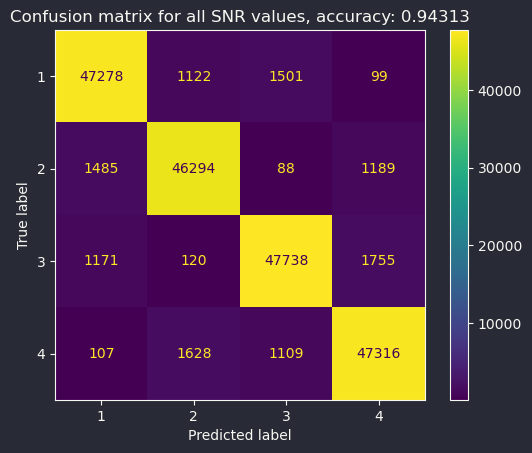

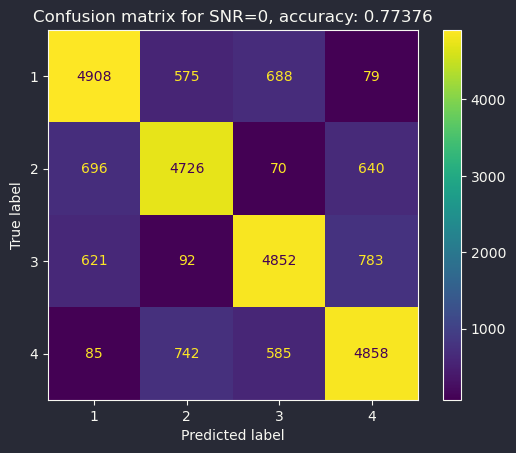

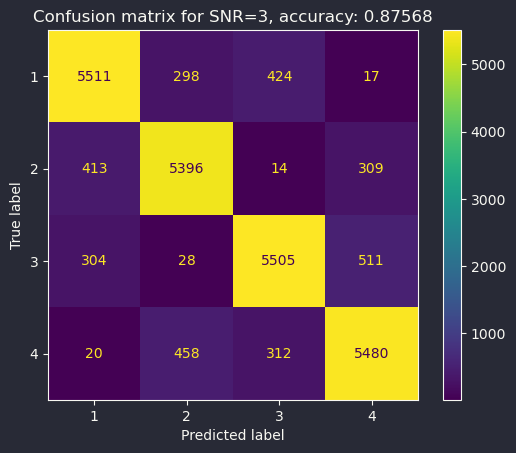

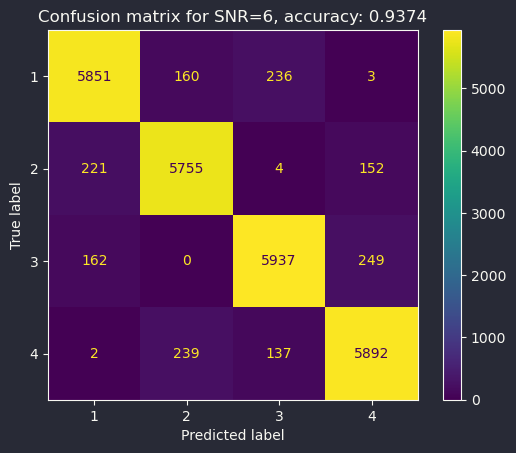

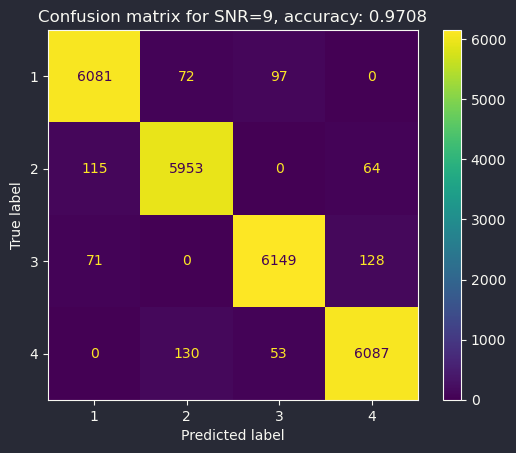

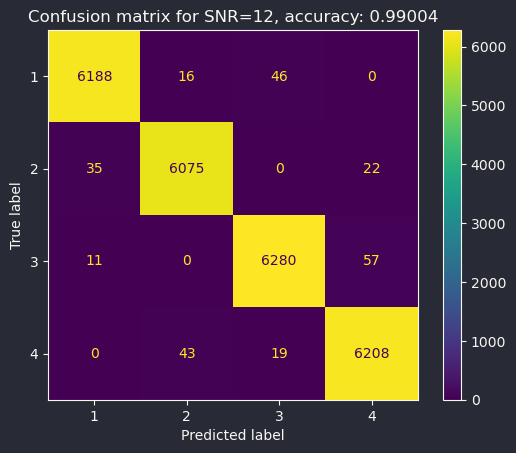

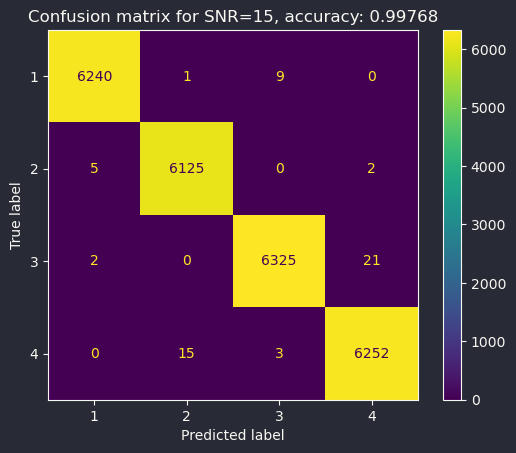

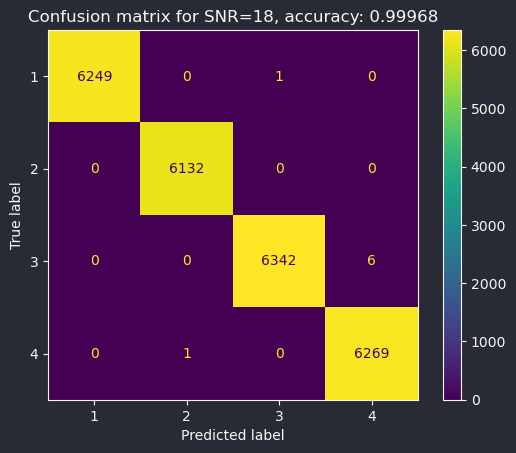

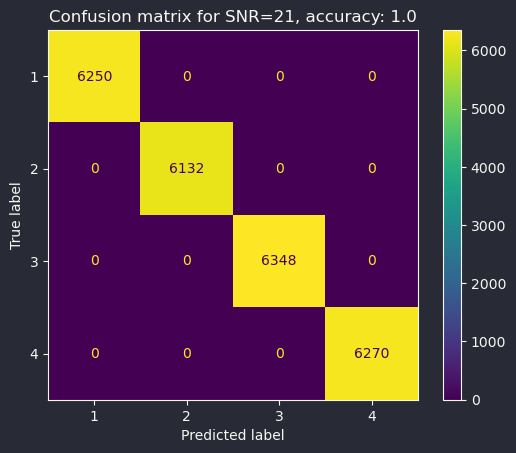

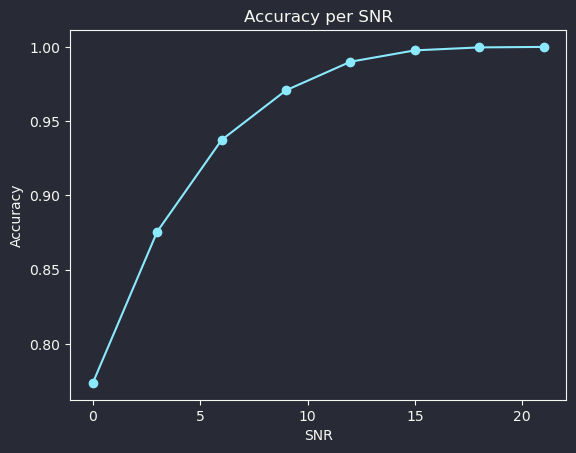

In [46]:
dataSet = DataParser("../data/DataForML.mat")

train_data, train_labels = dataSet.get_train_multipath()
test_data, test_labels = dataSet.get_test_multipath()

naiveBayes_multipath = NaiveBayes()

naiveBayes_multipath.train(train_data, train_labels, np.unique(train_labels))

predicted_labels = naiveBayes_multipath.predict(test_data, np.unique(train_labels))
visualize_data(predicted_labels, test_labels, allSNR=True, perSNR=True)